In [15]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np


In [2]:
df = pd.read_csv('favorability_om.csv')

In [3]:
df.columns

Index(['original_author', 'wsai_content_0', 'Page_Rank', 'Rank', 'topic',
       'author_display_name', 'bio', 'country', 'num_followers',
       'Footprint_Influence_Score',
       '0 **Context and Objective:**  \nWe are analyzing a batch of twe...'],
      dtype='object')

In [4]:
column_mapping = {
    col: 'favorability' if col.startswith('0 **Context and Objective:**') else
        'original_tweets' if col.startswith('wsai_content_0') else
        col
    for col in df.columns
}

# Rename the columns
df = df.rename(columns=column_mapping)

In [5]:
df['favorability'][0]

'{\n  "Google": {\n    "mentions": 0,\n    "average_score": 0.0\n  },\n  "OpenAI": {\n    "mentions": 0,\n    "average_score": 0.0\n  },\n  "Meta": {\n    "mentions": 0,\n    "average_score": 0.0\n  },\n  "Microsoft": {\n    "mentions": 0,\n    "average_score": 0.0\n  },\n  "IBM": {\n    "mentions": 0,\n    "average_score": 0.0\n  },\n  "Other": {\n    "mentions": 3,\n    "average_score": 8.0\n  }\n}'

In [6]:
def clean_json_string(json_str):
    """
    Clean and validate individual JSON strings, ensuring proper types and handling None values.
    """
    try:
        data = json.loads(json_str)
        # Ensure each brand has valid numeric values
        for brand in data:
            if data[brand]['mentions'] is None:
                data[brand]['mentions'] = 0
            if data[brand]['average_score'] is None:
                data[brand]['average_score'] = 0.0
            # Convert to correct types
            data[brand]['mentions'] = int(data[brand]['mentions'])
            data[brand]['average_score'] = float(data[brand]['average_score'])
        return json.dumps(data)
    except (json.JSONDecodeError, TypeError, KeyError):
        return pd.NA

def clean_favorability_data(df, column='favorability'):
    """
    Clean the favorability column in a dataframe and create a parsed version.
    
    Args:
        df (pd.DataFrame): Input dataframe
        column (str): Name of the column containing JSON strings
    
    Returns:
        pd.DataFrame: Cleaned dataframe with both string and parsed JSON columns
    """
    # Create a copy to avoid modifying the original
    df = df.copy()
    
    # Clean the JSON strings
    df[column] = df[column].apply(clean_json_string)
    
    # Remove rows with invalid JSON
    df = df.dropna(subset=[column])
    
    # Add parsed version for easier access
    parsed_column = f'parsed_{column}'
    df[parsed_column] = df[column].apply(json.loads)
    
    return df

# Usage:
df = clean_favorability_data(df)

In [8]:
df['favorability'][0]

'{"Google": {"mentions": 0, "average_score": 0.0}, "OpenAI": {"mentions": 0, "average_score": 0.0}, "Meta": {"mentions": 0, "average_score": 0.0}, "Microsoft": {"mentions": 0, "average_score": 0.0}, "IBM": {"mentions": 0, "average_score": 0.0}, "Other": {"mentions": 3, "average_score": 8.0}}'

In [10]:
def aggregate_favorability_data(df, column='favorability'):
    """
    Aggregate favorability data across all rows, calculating total mentions 
    and weighted sum scores for each brand.
    
    Args:
        df (pd.DataFrame): DataFrame containing favorability data
        column (str): Name of the column containing favorability data (can be JSON string or parsed dict)
    
    Returns:
        dict: Aggregated data for each brand with total mentions and weighted sum scores
    """
    aggregated_data = {}
    
    for idx, row in df.iterrows():
        # Handle both string and dict inputs
        brand_dict = json.loads(row[column]) if isinstance(row[column], str) else row[column]
        
        for brand, metrics in brand_dict.items():
            mentions = metrics['mentions']
            avg_score = metrics['average_score']
            
            if brand not in aggregated_data:
                aggregated_data[brand] = {
                    'total_mentions': 0,
                    'weighted_sum_scores': 0.0
                }
            
            aggregated_data[brand]['total_mentions'] += mentions
            if mentions is not None and avg_score is not None:
                aggregated_data[brand]['weighted_sum_scores'] += mentions * avg_score
    
    return aggregated_data


In [11]:
aggregated_results = aggregate_favorability_data(df, column='favorability')

In [12]:
aggregated_results

{'Google': {'total_mentions': 1477, 'weighted_sum_scores': 9825.240000000005},
 'OpenAI': {'total_mentions': 5291, 'weighted_sum_scores': 34654.429999999964},
 'Meta': {'total_mentions': 1947, 'weighted_sum_scores': 14019.899999999998},
 'Microsoft': {'total_mentions': 1006,
  'weighted_sum_scores': 6739.110000000001},
 'IBM': {'total_mentions': 358, 'weighted_sum_scores': 2634.55},
 'Other': {'total_mentions': 24444, 'weighted_sum_scores': 162209.9500000001}}

In [16]:
def create_favorability_plot(aggregated_data, figsize=(12, 8), bubble_scale=50, min_opacity=0.4):
    """
    Create an enhanced bubble plot showing brand favorability vs mentions.
    
    Args:
        aggregated_data (dict): Aggregated favorability data
        figsize (tuple): Figure size (width, height)
        bubble_scale (int): Scaling factor for bubble sizes
        min_opacity (float): Minimum opacity for bubbles
    """
    # Calculate average scores for each brand
    final_data = {
        brand: {
            "total_mentions": data["total_mentions"],
            "average_score": data["weighted_sum_scores"] / data["total_mentions"] if data["total_mentions"] > 0 else 0
        }
        for brand, data in aggregated_data.items()
    }
    
    # Prepare data
    brands = list(final_data.keys())
    mentions = [final_data[b]["total_mentions"] for b in brands]
    scores = [final_data[b]["average_score"] for b in brands]
    
    # Calculate bubble sizes with logarithmic scaling for better visualization
    max_mentions = max(mentions)
    bubble_sizes = [((m / max_mentions) ** 0.5) * bubble_scale * 100 for m in mentions]
    
    # Create plot
    plt.figure(figsize=figsize)
    
    # Create color map
    colors = plt.cm.viridis(np.linspace(0, 1, len(brands)))
    
    # Scatter plot with enhanced styling
    scatter = plt.scatter(
        scores,
        mentions,
        s=bubble_sizes,
        alpha=min_opacity,
        c=colors,
        edgecolor='white',
        linewidth=2
    )
    
    # Add labels with improved positioning
    for i, brand in enumerate(brands):
        # Calculate adjusted position for label
        x = scores[i]
        y = mentions[i]
        plt.annotate(
            brand,
            (x, y),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=10,
            fontweight='bold',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1)
        )
    
    # Enhance the plot styling
    plt.xlabel("Favorability Score", fontsize=12, fontweight='bold')
    plt.ylabel("Number of Mentions", fontsize=12, fontweight='bold')
    plt.title("Brand Mentions vs. Favorability Score", fontsize=14, fontweight='bold', pad=20)
    
    # Add grid with enhanced styling
    plt.grid(True, alpha=0.2, linestyle='--')
    
    # Add thousand separator to y-axis
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Adjust layout
    plt.tight_layout()
    
    return plt

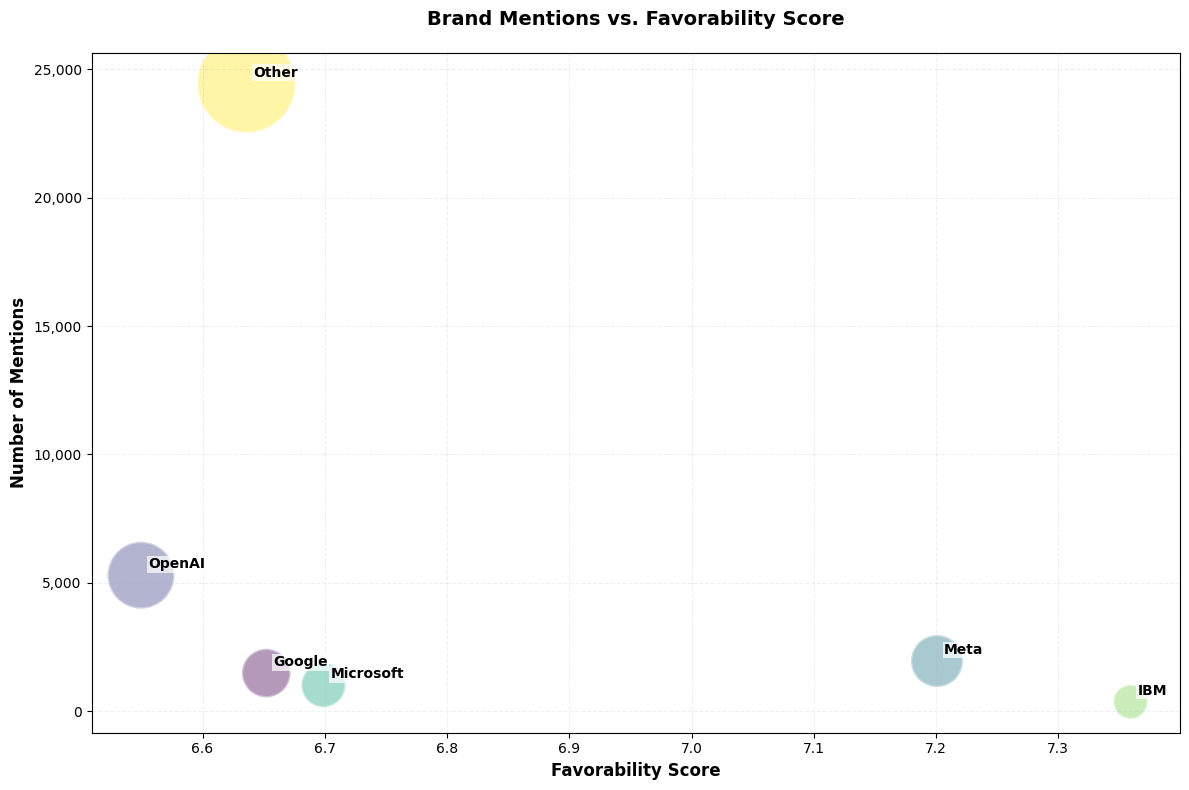

In [17]:
# Usage:
# First, make sure you have your aggregated data
aggregated_results = aggregate_favorability_data(df)

# Create and show the plot
plot = create_favorability_plot(aggregated_results)
plot.show()

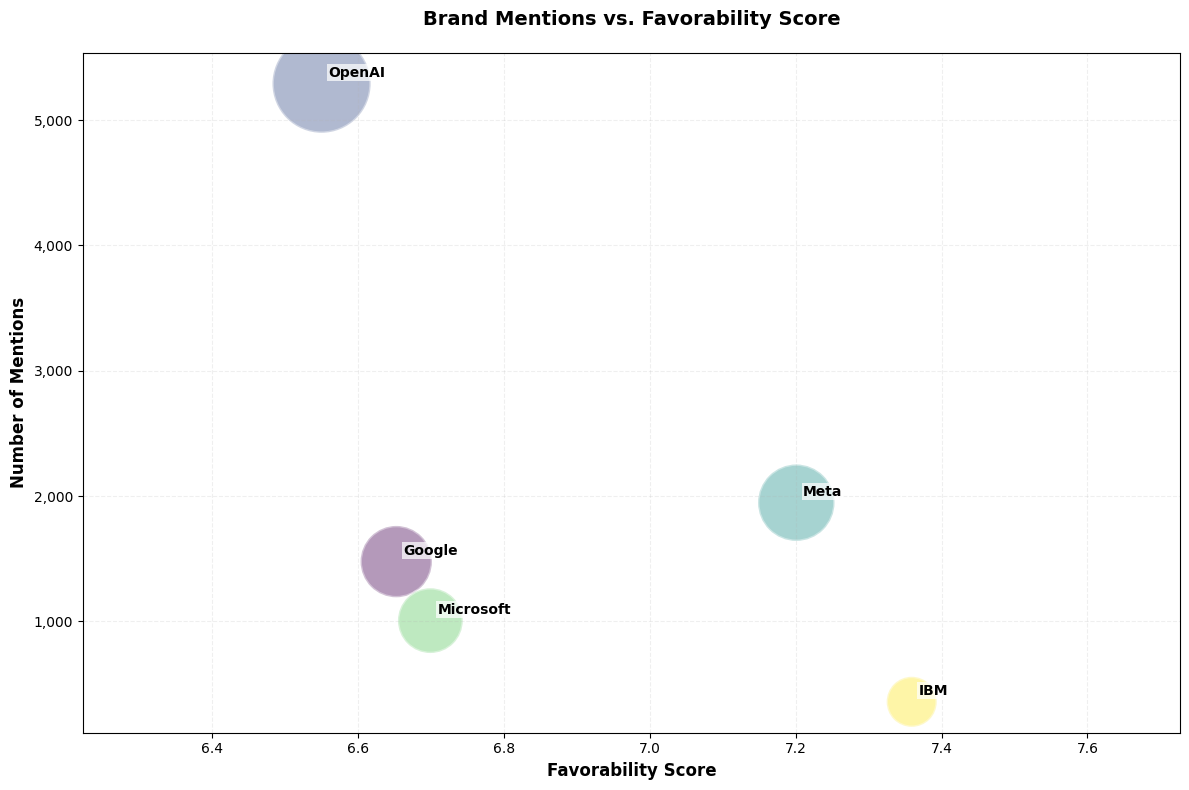

In [18]:
def create_favorability_plot(aggregated_data, figsize=(12, 8), bubble_scale=50, min_opacity=0.4):
    """
    Create an enhanced bubble plot showing brand favorability vs mentions.
    """
    # Calculate average scores and remove "Other" category
    final_data = {
        brand: {
            "total_mentions": data["total_mentions"],
            "average_score": data["weighted_sum_scores"] / data["total_mentions"] if data["total_mentions"] > 0 else 0
        }
        for brand, data in aggregated_data.items()
        if brand != "Other"  # Exclude "Other" category
    }
    
    # Prepare data
    brands = list(final_data.keys())
    mentions = [final_data[b]["total_mentions"] for b in brands]
    scores = [final_data[b]["average_score"] for b in brands]
    
    # Calculate bubble sizes
    max_mentions = max(mentions)
    bubble_sizes = [((m / max_mentions) ** 0.5) * bubble_scale * 100 for m in mentions]
    
    # Create plot
    plt.figure(figsize=figsize)
    
    # Create color map
    colors = plt.cm.viridis(np.linspace(0, 1, len(brands)))
    
    # Scatter plot
    scatter = plt.scatter(
        scores,
        mentions,
        s=bubble_sizes,
        alpha=min_opacity,
        c=colors,
        edgecolor='white',
        linewidth=2
    )
    
    # Add labels
    for i, brand in enumerate(brands):
        x = scores[i]
        y = mentions[i]
        plt.annotate(
            brand,
            (x, y),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=10,
            fontweight='bold',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1)
        )
    
    # Styling
    plt.xlabel("Favorability Score", fontsize=12, fontweight='bold')
    plt.ylabel("Number of Mentions", fontsize=12, fontweight='bold')
    plt.title("Brand Mentions vs. Favorability Score", fontsize=14, fontweight='bold', pad=20)
    
    # Add grid
    plt.grid(True, alpha=0.2, linestyle='--')
    
    # Format y-axis with thousand separator
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Adjust x-axis to minimize empty space
    x_min = min(scores) * 0.95  # Add 5% padding
    x_max = max(scores) * 1.05
    plt.xlim(x_min, x_max)
    
    # Adjust layout
    plt.tight_layout()
    
    return plt

# Usage:
aggregated_results = aggregate_favorability_data(df)
plot = create_favorability_plot(aggregated_results)
plot.show()